Activate eelbrain-env and run under Python 3.11.14

In [2]:
from pathlib import Path 
import numpy as np

from scipy.io import loadmat
from scipy.signal import resample, butter, filtfilt, decimate

import mne
from mne import find_events
from mne.channels import make_dig_montage


import eelbrain

import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from scipy.stats import pearsonr

import pretty_midi
import os

from collections import defaultdict




In [3]:

# Define the dataset root; replace it with the proper path if you downloaded the dataset in a different location
DATA_ROOT = Path('../liberi_dataset/doi_10_5061_dryad_g1jwstqmh__v20211008')

# Define paths that will be used throughout
STIMULUS_DIR = DATA_ROOT / 'diliBach_midi_4dryad'  ## this has the midi files
EEG_DIR = DATA_ROOT / 'diliBach_4dryad_CND'       ## this has the matlab files 
SURPRISAL_FILE = '../SigMA-IDyOMpy/codeForPaper-IDyOMpy-/benchmark_results/forBenchmark_IDyOMpy/eLife_trained_on_mixed2.mat'

# Load the raw EEG file for a single subject and a specified frequency band
# Adjust subject index and the low/high frequency values accordingly

SUBJECTS = [
    'Sub1',
    'Sub2',
    # 'Sub3',
    # 'Sub4',
    # 'Sub5',
    # 'Sub6',
    # 'Sub7',
    # 'Sub8',
    # 'Sub9',
    # 'Sub10',
    # 'Sub11',
    # 'Sub12',
    # 'Sub13',
    # 'Sub14',
    # 'Sub15',
    # 'Sub16', 
    # 'Sub17', 
    # 'Sub18', 
    # 'Sub19', 
    # 'Sub20'
    ]
LOW_FREQUENCY = 4
HIGH_FREQUENCY = 8

## Load EEG Data

In [14]:
def load_subject_raw_eeg(filepath, subject):
    
    # Extract subject index from string (e.g., 'S18' -> 18)
    subject_idx = int(subject[3:])
        
    # Load the .mat file
    mat_data = loadmat(filepath, struct_as_record=False, squeeze_me=True)
    eeg = mat_data["eeg"]
    target_fs = 500  # Target sampling frequency
    orig_fs = int(eeg.fs)
    resample_needed = orig_fs != target_fs
    for i in range(len(eeg.data)):
        
        # Scale data 
        trial_data = 100 * eeg.data[i].astype(np.float32) / np.iinfo(np.int32).max
        
        # Resample to 500Hz, to be consistent with Alice
        if resample_needed:
            n_samples = int(trial_data.shape[0] * target_fs / orig_fs)
            trial_data = resample(trial_data, n_samples, axis=0)
        
        eeg.data[i] = trial_data
        
    # Extract key information into a dictionary
    raw_data = {
        'trials': eeg.data,
        'fs': target_fs,
        'chanlocs': eeg.chanlocs,
        'pad_start': int(eeg.paddingStartSample * target_fs / orig_fs) if resample_needed else int(eeg.paddingStartSample),
        'subject_type': 'Musician' if subject_idx >= 11 else 'Non-musician'
    }
    
    print(f"✓ Loaded {raw_data['subject_type']} (Subject {subject})")
    print(f"  - {len(raw_data['trials'])} trials, {raw_data['trials'][0].shape[1]} channels")
    
    return raw_data

In [12]:
def create_mne_raw_from_loaded(subject_data):
    """Convert already-loaded Bach data to MNE Raw object with channel positions."""
    
    trials = subject_data['trials']
    sfreq = subject_data['fs']
    pad_start = subject_data['pad_start']    
    chanlocs = subject_data['chanlocs']
    
    # Get channel names and positions
    ch_names = []
    positions = []
    
    for ch in chanlocs:
        
        # Get channel label        
        ch_names.append(ch.labels)
        
        # Get channel positions if available
        if hasattr(ch, 'X') and hasattr(ch, 'Y') and hasattr(ch, 'Z'):
            positions.append([ch.Y, ch.X, ch.Z])
    
    # Concatenate all trials
    all_trials = []
    trial_lengths = []
    
    for trial in trials:
        # Remove padding and transpose to channels x time
        trial_clean = trial[pad_start:, :].T
        all_trials.append(trial_clean)
        trial_lengths.append(trial_clean.shape[1])
    
    # Concatenate
    eeg_continuous = np.hstack(all_trials)
    n_channels, n_samples = eeg_continuous.shape
    
    # Create stimulus channel with trial markers
    stim_data = np.zeros((1, n_samples))
    
    # Mark all 30 trial onsets
    current_sample = 0
    marker_positions = []
    for i in range(30):
        # Place marker at current position (offset by 1 if at sample 0)
        marker_sample = 1 if current_sample == 0 else current_sample
        stim_data[0, marker_sample] = i + 1  # Use 1-30 as event IDs
        marker_positions.append((i+1, marker_sample))
        current_sample += trial_lengths[i]  # Move to next trial start
        
    # Combine EEG and stim
    data_with_stim = np.vstack([eeg_continuous, stim_data])
    
    # Channel setup
    ch_names = ch_names + ['STI']
    ch_types = ['eeg'] * n_channels + ['stim']
    
    # Create Raw
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(data_with_stim, info)
        
    montage = make_dig_montage(
        ch_pos=dict(zip(ch_names[:n_channels], positions)),
        coord_frame='head'
    )
    raw.set_montage(montage)
    return raw

In [7]:
def create_eelbrain_events(raw):
    """Create eelbrain events with correct column structure."""
    
    # Find events in the MNE raw object
    mne_events = mne.find_events(raw, stim_channel='STI', verbose=False)
    
    # Create eelbrain Dataset with the required columns
    events_data = {
        'i_start': mne_events[:, 0],  # Sample indices
        'trigger': mne_events[:, 2],  # Event IDs (1-30)
        'event': mne_events[:, 2]     # Same as trigger (1-30)
    }
    
    events = eelbrain.Dataset(events_data)

    # Link raw data to events for use in variable_length_epochs
    events.info['raw'] = raw
    return events

In [8]:
def make_surprisal_timeseries(
    midi_path,
    surprisal_vec,
    sfreq,
    n_times
):
    """
    Create a time-varying surprisal predictor aligned to EEG time.

    Returns
    -------
    surprisal_ts : np.ndarray, shape (n_times,)
    """
    pm = pretty_midi.PrettyMIDI(midi_path)

    # Collect note onsets
    onsets = []
    for instrument in pm.instruments:
        for note in instrument.notes:
            onsets.append(note.start)

    onsets = np.array(sorted(onsets))

    # Align lengths
    n = min(len(onsets), len(surprisal_vec))
    onsets = onsets[:n]
    surprisal_vec = surprisal_vec[:n]

    # Initialize continuous time series
    surprisal_ts = np.zeros(n_times)

    for t, s in zip(onsets, surprisal_vec):
        sample = int(round(t * sfreq))
        if 0 <= sample < n_times:
            surprisal_ts[sample] += s  # impulse

    return surprisal_ts


In [9]:
def get_midi_duration_seconds(midi_path):
    pm = pretty_midi.PrettyMIDI(midi_path)
    return pm.get_end_time()

## Main Execution

In [19]:
# Load the provided envelope from dataStim.mat
stim_mat = loadmat(EEG_DIR / "dataStim.mat", struct_as_record=False, squeeze_me=True)
stim = stim_mat["stim"]
stim_fs = int(stim.fs)

idyom_output = loadmat(SURPRISAL_FILE, squeeze_me=True)

# Pre-compute unique song IDs
unique_song_ids = np.unique(stim.stimIdxs)

# Pre-load all MIDI durations in one pass 
midi_durations = {}
for song_id in unique_song_ids:
    midi_path = STIMULUS_DIR / f"audio{song_id}.mid"
    midi_durations[song_id] = get_midi_duration_seconds(midi_path)

# Pre-process all surprisal data
surprisal_data = {}
for song_id in unique_song_ids:
    surprisal_key = f"audio{song_id}"
    if surprisal_key not in idyom_output:
        raise KeyError(f"{surprisal_key} not found in SURPRISAL_FILE")
    surprisal_data[song_id] = np.asarray(idyom_output[surprisal_key]).flatten()

all_events = []
stim_surprisal_ndvars = {}

for SUBJECT in SUBJECTS:
    eeg_data = load_subject_raw_eeg(EEG_DIR / f'data{SUBJECT}.mat', SUBJECT)
    raw = create_mne_raw_from_loaded(eeg_data)
    
    # Filter the raw data to the desired band
    raw.filter(LOW_FREQUENCY, HIGH_FREQUENCY, n_jobs=1)
    
    # Plot topographic EEG butterfly plot
    t0 = 0
    xlim = [t0, t0 + 5]
    p = eelbrain.plot.TopoButterfly(raw, t=t0+1, xlim=xlim, vmax=1e-4, h=3, w=10, clip='circle')
    
    # Create events with correct structure
    events = create_eelbrain_events(raw)
    
    sfreq = raw.info['sfreq']
    print("sfreq:", sfreq)
    dt = 1 / sfreq
    print("dt:", dt)

    # Vectorized processing of all songs at once
    if not stim_surprisal_ndvars:  # Only compute once
        # Pre-compute n_times for all songs
        n_times_array = np.ceil(np.array([midi_durations[sid] for sid in unique_song_ids]) * sfreq).astype(int)
        
        # Process all songs
        for idx, song_id in enumerate(unique_song_ids):
            n_times = n_times_array[idx]
            midi_path = STIMULUS_DIR / f"audio{song_id}.mid"
            
            surprisal_ts = make_surprisal_timeseries(
                midi_path=midi_path,
                surprisal_vec=surprisal_data[song_id],
                sfreq=sfreq,
                n_times=n_times
            )
            
            # Convert to NDVar
            time = eelbrain.UTS(0, dt, n_times)
            surprisal_ndvar = eelbrain.NDVar(
                surprisal_ts,
                dims=(time,),
                name="surprisal"
            )
            
            surprisal_ndvar = eelbrain.resample(surprisal_ndvar, 100)
            stim_surprisal_ndvars[song_id] = surprisal_ndvar
            
    surprisal_per_event = []

    # envelopes = []

    for stimulus_id in events['event']:
        print(stimulus_id)
        song_id = stim.stimIdxs[stimulus_id - 1]
        surprisal_per_event.append(stim_surprisal_ndvars[song_id])

    events['surprisal'] = surprisal_per_event
    
    events['duration'] = eelbrain.Var([surprisal.time.tstop for surprisal in events['surprisal']])
    
    events['eeg'] = eelbrain.load.mne.variable_length_epochs(events, 0, tstop='duration', decim=5, connectivity='auto')
    
    # Estimate the TRF: boosting(y, x, tstart, tstop[, scale_data, ...])
    trf = eelbrain.boosting('eeg', 'surprisal', -0.150, 0.750, data=events, basis=0.050, partitions=4, error='l1')

    # Plot the TRF
    t = trf.h.std('sensor').argmax('time')
    p = eelbrain.plot.TopoButterfly(trf.h, t=t, w=10, h=4, clip='circle')

    # Alternative visualization as array image
    p = eelbrain.plot.TopoArray(trf.h, t=[0.150, 0.350, 0.500], w=6, h=4, clip='circle')


OSError: Reader needs file name or open file-like object

In [20]:
print(n_times)

88479


In [18]:
!pwd


/Users/arianapereira/Documents/Masters/Projects/SigMA/TRF


In [9]:
surprisal_per_event = []

# envelopes = []

for stimulus_id in events['event']:
    song_id = stim.stimIdxs[stimulus_id - 1]
    surprisal_per_event.append(stim_surprisal_ndvars[song_id])
    surprisal_per_event

events['surprisal'] = surprisal_per_event

events

#,i_start,trigger,event,surprisal,duration,eeg
0,1,1,1,<NDVar 'surp...,157.19,<NDVar: 64 s...
1,79963,2,2,<NDVar 'surp...,153.6,<NDVar: 64 s...
2,157481,3,3,<NDVar 'surp...,118.29,<NDVar: 64 s...
3,218059,4,4,<NDVar 'surp...,134.63,<NDVar: 64 s...
4,286458,5,5,<NDVar 'surp...,165.48,<NDVar: 64 s...
5,369824,6,6,<NDVar 'surp...,197.31,<NDVar: 64 s...
6,469978,7,7,<NDVar 'surp...,173.05,<NDVar: 64 s...
7,557065,8,8,<NDVar 'surp...,182.96,<NDVar: 64 s...
8,648670,9,9,<NDVar 'surp...,134.42,<NDVar: 64 s...
9,716256,10,10,<NDVar 'surp...,176.96,<NDVar: 64 s...


In [10]:
# Extract the stimulus duration (in seconds) from the envelopes
events['duration'] = eelbrain.Var([surprisal.time.tstop for surprisal in events['surprisal']])

events

#,i_start,trigger,event,surprisal,duration,eeg
0,1,1,1,<NDVar 'surp...,157.19,<NDVar: 64 s...
1,79963,2,2,<NDVar 'surp...,153.6,<NDVar: 64 s...
2,157481,3,3,<NDVar 'surp...,118.29,<NDVar: 64 s...
3,218059,4,4,<NDVar 'surp...,134.63,<NDVar: 64 s...
4,286458,5,5,<NDVar 'surp...,165.48,<NDVar: 64 s...
5,369824,6,6,<NDVar 'surp...,197.31,<NDVar: 64 s...
6,469978,7,7,<NDVar 'surp...,173.05,<NDVar: 64 s...
7,557065,8,8,<NDVar 'surp...,182.96,<NDVar: 64 s...
8,648670,9,9,<NDVar 'surp...,134.42,<NDVar: 64 s...
9,716256,10,10,<NDVar 'surp...,176.96,<NDVar: 64 s...


In [11]:
# Extract EEG data corresponding exactly to the timing of the envelopes
events['eeg'] = eelbrain.load.mne.variable_length_epochs(events, 0, tstop='duration', decim=5, connectivity='auto')

events

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 78591 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 76796 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 59141 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 67311 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items a

/var/folders/r4/z65_5ryn59z3_3lyzgvxdcm40000gn/T/ipykernel_25714/852649129.py:2: DeprecationWarning: Argument 'connectivity' is deprecated; use 'adjacency' instead. Deprecated since eelbrain 0.41. Support will be removed in eelbrain 0.42.
  events['eeg'] = eelbrain.load.mne.variable_length_epochs(events, 0, tstop='duration', decim=5, connectivity='auto')


0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 67206 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 88476 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 78591 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 76796 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied

#,i_start,trigger,event,surprisal,duration,eeg
0,1,1,1,<NDVar 'surp...,157.19,<NDVar: 64 s...
1,79963,2,2,<NDVar 'surp...,153.6,<NDVar: 64 s...
2,157481,3,3,<NDVar 'surp...,118.29,<NDVar: 64 s...
3,218059,4,4,<NDVar 'surp...,134.63,<NDVar: 64 s...
4,286458,5,5,<NDVar 'surp...,165.48,<NDVar: 64 s...
5,369824,6,6,<NDVar 'surp...,197.31,<NDVar: 64 s...
6,469978,7,7,<NDVar 'surp...,173.05,<NDVar: 64 s...
7,557065,8,8,<NDVar 'surp...,182.96,<NDVar: 64 s...
8,648670,9,9,<NDVar 'surp...,134.42,<NDVar: 64 s...
9,716256,10,10,<NDVar 'surp...,176.96,<NDVar: 64 s...


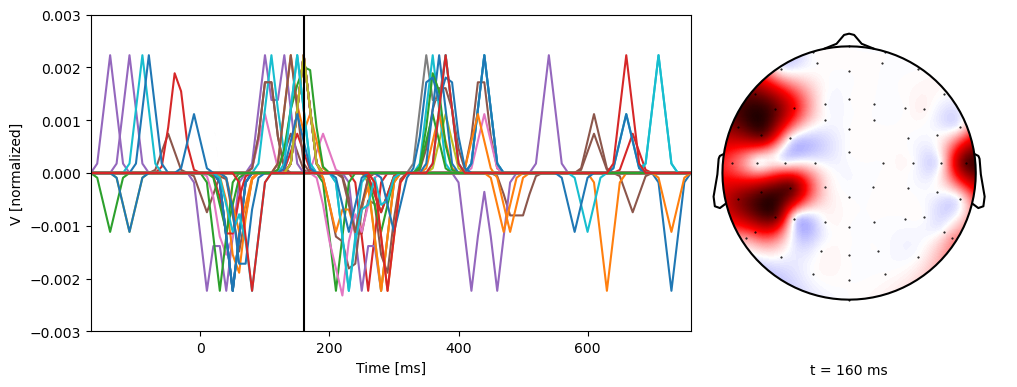

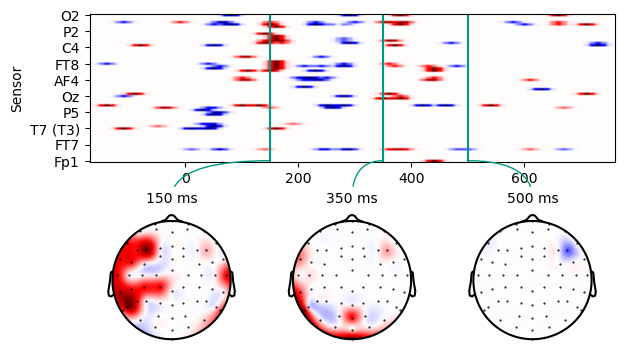

In [12]:
# Estimate the TRF: boosting(y, x, tstart, tstop[, scale_data, ...])
trf = eelbrain.boosting('eeg', 'surprisal', -0.150, 0.750, data=events, basis=0.050, partitions=4, error='l1')

# Plot the TRF
t = trf.h.std('sensor').argmax('time')
p = eelbrain.plot.TopoButterfly(trf.h, t=t, w=10, h=4, clip='circle')

# Alternative visualization as array image
p = eelbrain.plot.TopoArray(trf.h, t=[0.150, 0.350, 0.500], w=6, h=4, clip='circle')


In [13]:
try:
    %load_ext autoreload
    %autoreload 2
    print("Autoreload is enabled.")
except Exception as e:
    print("Autoreload is not available in this environment.", e)

Autoreload is enabled.


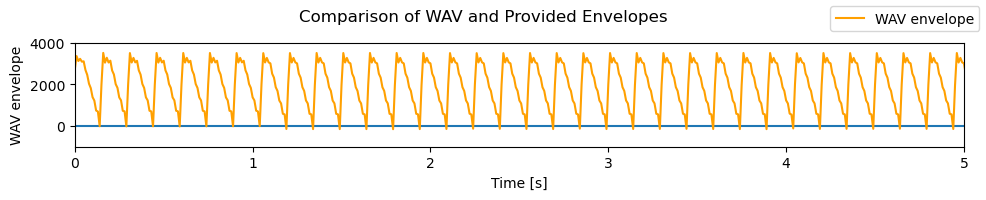

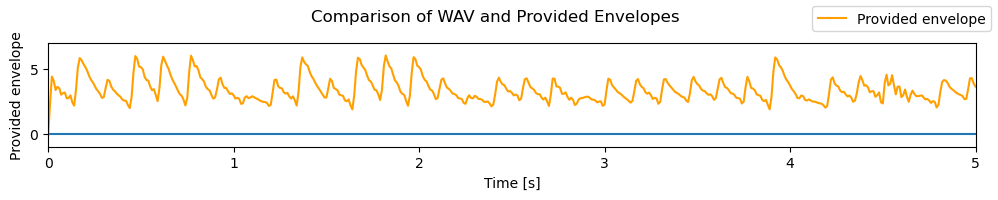

In [20]:
import constants
import eelbrain
from scipy.io import loadmat

# WAV ENVELOPE

# Define trial index to inspect
trial_idx = 0  # corresponds to stimulus "1.wav"

# Load the WAV file for this trial
wav = eelbrain.load.wav(constants.WAV_DIR / f"{trial_idx+1}.wav")

# Compute its envelope
wav_envelope = wav.envelope()

# Resample to 100 Hz for TRF-style alignment
wav_envelope = eelbrain.resample(wav_envelope, 100)


# PROVIDED ENVELOPE

# Load the provided envelope from dataStim.mat
stim_mat = loadmat(constants.EEG_DIR / "dataStim.mat", struct_as_record=False, squeeze_me=True)
stim = stim_mat["stim"]
stim_fs = int(stim.fs)

# Extract the precomputed envelope
provided_envelope = stim.data[0][trial_idx]

# Create an NDVar for the provided envelope
time = eelbrain.UTS(0, 1/stim_fs, len(provided_envelope))
provided_env_ndvar = eelbrain.NDVar(provided_envelope, (time,), name='provided_envelope')

# Resample to 100 Hz
provided_env_ndvar = eelbrain.resample(provided_env_ndvar, 100)


# Assign names for legend using .copy(name=...)
wav_envelope_named = wav_envelope.copy(name='WAV envelope')
provided_env_named = provided_env_ndvar.copy(name='Provided envelope')

# Plot with legend from names
p = eelbrain.plot.UTS(
    [wav_envelope_named],
    legend=True,
    axh=2, w=10, columns=1, xlim=(0, 5),
    title='Comparison of WAV and Provided Envelopes'
)
p.add_hline(0, zorder=0)

p = eelbrain.plot.UTS(
    [provided_env_named],
    legend=True,
    axh=2, w=10, columns=1, xlim=(0, 5),
    title='Comparison of WAV and Provided Envelopes'
)
p.add_hline(0, zorder=0)

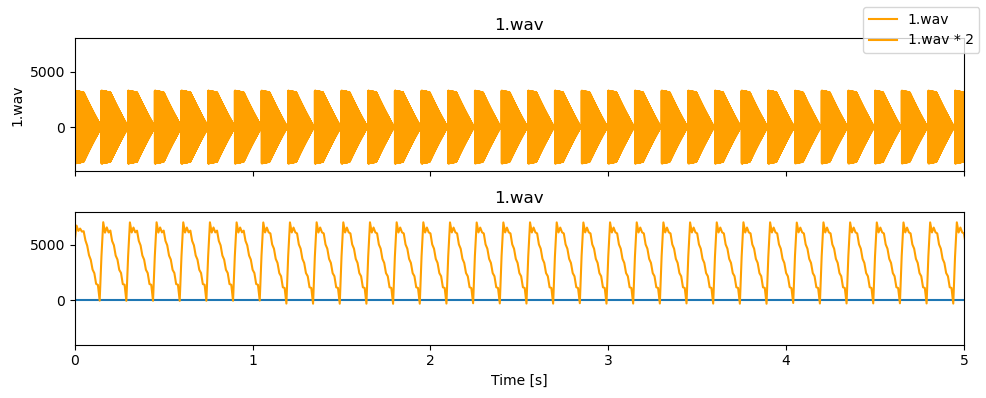

In [16]:
# Load the sound file corresponding to trigger 1
wav = eelbrain.load.wav(constants.WAV_DIR / f'1.wav')

# Compute the acoustic envelope
envelope = wav.envelope()

# Filter the envelope
envelope = eelbrain.resample(envelope, 100)

# Visualize the first 5 seconds
p = eelbrain.plot.UTS([wav, envelope * 2], axh=2, w=10, columns=1, xlim=5)

# Add y=0 as reference
p.add_hline(0, zorder=0)

In [18]:
# Generate the acoustic envelope for all trials in this dataset
envelopes = []
for stimulus_id in events['event']:
    song_id = stimulus_id % 10
    song_id = song_id if song_id != 0 else 10
    wav = eelbrain.load.wav(constants.WAV_DIR / f'{song_id}.wav')
    envelope = wav.envelope()
    envelope = eelbrain.resample(envelope, 100)
    envelopes.append(envelope)

# Add the envelopes to the events table
events['envelope'] = envelopes

# Add a second predictor corresponding to acoustic onsets
events['onsets'] = [envelope.diff('time').clip(0) for envelope in envelopes]

events

#,i_start,trigger,event,surprisal,duration,eeg,envelope,onsets
0,1,1,1,<NDVar 'surp...,157.19,<NDVar: 64 s...,<NDVar '1.wa...,<NDVar '1.wa...
1,79963,2,2,<NDVar 'surp...,153.6,<NDVar: 64 s...,<NDVar '2.wa...,<NDVar '2.wa...
2,157481,3,3,<NDVar 'surp...,118.29,<NDVar: 64 s...,<NDVar '3.wa...,<NDVar '3.wa...
3,218059,4,4,<NDVar 'surp...,134.63,<NDVar: 64 s...,<NDVar '4.wa...,<NDVar '4.wa...
4,286458,5,5,<NDVar 'surp...,165.48,<NDVar: 64 s...,<NDVar '5.wa...,<NDVar '5.wa...
5,369824,6,6,<NDVar 'surp...,197.31,<NDVar: 64 s...,<NDVar '6.wa...,<NDVar '6.wa...
6,469978,7,7,<NDVar 'surp...,173.05,<NDVar: 64 s...,<NDVar '7.wa...,<NDVar '7.wa...
7,557065,8,8,<NDVar 'surp...,182.96,<NDVar: 64 s...,<NDVar '8.wa...,<NDVar '8.wa...
8,648670,9,9,<NDVar 'surp...,134.42,<NDVar: 64 s...,<NDVar '9.wa...,<NDVar '9.wa...
9,716256,10,10,<NDVar 'surp...,176.96,<NDVar: 64 s...,<NDVar '10.w...,<NDVar '10.w...


In [19]:
# Extract the stimulus duration (in seconds) from the envelopes
events['duration2'] = eelbrain.Var([envelope.time.tstop for envelope in events['envelope']])
events

#,i_start,trigger,event,surprisal,duration,eeg,envelope,onsets,duration2
0,1,1,1,<NDVar 'surp...,157.19,<NDVar: 64 s...,<NDVar '1.wa...,<NDVar '1.wa...,158.04
1,79963,2,2,<NDVar 'surp...,153.6,<NDVar: 64 s...,<NDVar '2.wa...,<NDVar '2.wa...,153.1
2,157481,3,3,<NDVar 'surp...,118.29,<NDVar: 64 s...,<NDVar '3.wa...,<NDVar '3.wa...,119.29
3,218059,4,4,<NDVar 'surp...,134.63,<NDVar: 64 s...,<NDVar '4.wa...,<NDVar '4.wa...,134.5
4,286458,5,5,<NDVar 'surp...,165.48,<NDVar: 64 s...,<NDVar '5.wa...,<NDVar '5.wa...,164.73
5,369824,6,6,<NDVar 'surp...,197.31,<NDVar: 64 s...,<NDVar '6.wa...,<NDVar '6.wa...,198.31
6,469978,7,7,<NDVar 'surp...,173.05,<NDVar: 64 s...,<NDVar '7.wa...,<NDVar '7.wa...,172.17
7,557065,8,8,<NDVar 'surp...,182.96,<NDVar: 64 s...,<NDVar '8.wa...,<NDVar '8.wa...,181.21
8,648670,9,9,<NDVar 'surp...,134.42,<NDVar: 64 s...,<NDVar '9.wa...,<NDVar '9.wa...,133.17
9,716256,10,10,<NDVar 'surp...,176.96,<NDVar: 64 s...,<NDVar '10.w...,<NDVar '10.w...,177.1


In [ ]:
p = eelbrain.plot.TopoButterfly(trf.trf.h, t=t, w=10, h=4, clip='circle')

In [ ]:
p = eelbrain.plot.TopoArray(trf.trf.h, t=[0.150, 0.350, 0.500], w=6, h=4, clip='circle')